# Setup

In [1]:
# Import needed libraries
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import nflreadpy as nfl
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
# Set display options
pd.set_option('display.max_rows', 1000)

# Initial data loading

In [3]:
team_stats = nfl.load_team_stats(True)
team_stats = team_stats.to_pandas()
team_stats

,season,week,team,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,passing_interceptions,...,pat_made,pat_att,pat_missed,pat_blocked,pat_pct,gwfg_made,gwfg_att,gwfg_missed,gwfg_blocked,gwfg_distance
0,1999,1,ARI,REG,PHI,25,48,274,1,3,...,1,1,0,0,1.0,1,1,0,0,31
1,1999,1,ATL,REG,MIN,18,31,290,1,0,...,2,2,0,0,1.0,0,0,0,0,0
2,1999,1,BUF,REG,IND,22,42,300,1,2,...,0,0,0,0,NaN,0,0,0,0,0
3,1999,1,CAR,REG,NO,16,32,207,1,1,...,1,1,0,0,1.0,0,0,0,0,0
4,1999,1,CHI,REG,KC,31,47,322,2,0,...,2,2,0,0,1.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14172,2025,7,SEA,REG,HOU,17,32,213,1,2,...,3,3,0,0,1.0,0,0,0,0,0
14173,2025,7,SF,REG,ATL,17,26,152,0,1,...,2,2,0,0,1.0,0,0,0,0,0
14174,2025,7,TB,REG,DET,28,50,228,1,1,...,0,0,0,0,NaN,0,0,0,0,0
14175,2025,7,TEN,REG,NE,25,34,255,1,1,...,1,1,0,0,1.0,0,0,0,0,0


# Preprocessing

In [4]:
def preprocess_team_data(df):
    '''
    -Preprocesses/cleans up the raw df from nfl.load_team_stats
    -Adds features for previous game, current season, and previous 
        season stats for both team and opponent

    Parameters:
    df - original df returned from nfl.load_team_stats

    Returns:
    df - data in clean form
    '''

    # # # # # # # # #
    # Preprocessing #
    # # # # # # # # #

    df = df.query('season >= 2007').copy()

    # Duplicate columns
    df = df.drop(['receiving_tds', 
                  'receiving_first_downs', 
                  'receiving_2pt_conversions', 
                  'receiving_air_yards', 
                  'receptions',
                  'receiving_yards'], axis=1)
    # Irrelevant columns
    df = df.drop(['fg_made_list',
                  'fg_missed_list',
                  'fg_blocked_list'], axis=1)
    
    # Define the points_scored column based on TDs, PATs, FGs, and 2pt conversions
    df['points_scored'] = (6 * (df['passing_tds'] + 
                                df['rushing_tds'] +
                                df['special_teams_tds'] +
                                df['def_tds']) + 
                           3 * df['fg_made'] +
                           2 * (df['passing_2pt_conversions'] +
                                df['rushing_2pt_conversions']) +
                           1 * df['pat_made'])
    
    # Add opponent_points_scored
    opp_points_scored_df = df[['season', 'week', 'team', 'points_scored']]
    opp_points_scored_df = opp_points_scored_df.rename(columns={'team': 'opponent_team', 
                                                                'points_scored': 'opponent_points_scored'})
    df = df.merge(opp_points_scored_df, on=['season', 'week', 'opponent_team'], how='inner')

    # target variable: 1 if win, 0.5 if draw, 0 is loss
    df['outcome'] = (np.sign(df['points_scored'] - df['opponent_points_scored']) / 2) + 0.5 
    
    # Make sure there's no duplicate (season, week, team) combinations
    if df.duplicated(subset=["season", "week", "team"]).any():
        raise ValueError('Error: duplicate games')

    # # # # # # # # #
    # Add Features  #
    # # # # # # # # #
    
    # Add previous game features
    cols = df.columns
    keep_cols = ['season', 'week', 'team', 'season_type', 'opponent_team', 'points_scored']
    prev_cols = [col for col in cols if col not in keep_cols] + ['points_scored']

    # Shift all the stats so that we only know last game's stats
    df = df.sort_values(by=['team', 'season', 'week']).reset_index(drop=True)
    prev_game_df = df.groupby('team')[prev_cols + ['week']].shift(1).add_prefix('previous_game_')
    df = pd.concat([df, prev_game_df], axis=1)

    # Add opponent prev_game info
    df = df.sort_values(by=['team', 'season', 'week']).reset_index(drop=True)
    opp_prev_game_df = df[['team', 'season', 'week'] + list(prev_game_df.columns)].copy()
    opp_prev_game_df = opp_prev_game_df.rename(columns={'team': 'opponent_team'})
    opp_prev_game_df = opp_prev_game_df.rename(columns=lambda x: x.replace('previous_game_', 'opponent_previous_game_') if x.startswith('previous_game_') else x)
    df = df.merge(opp_prev_game_df, on=['season', 'week', 'opponent_team'], how='inner')

    # Add current season averages for team and opponent
    # Team
    df = df.sort_values(by=['team', 'season', 'week']).reset_index(drop=True)
    df_copy = df.copy()
    team_season_avg_df = (df_copy
                          .groupby(['team', 'season'])[prev_cols]
                          .expanding()
                          .mean()
                          .shift(1)
                          .reset_index(drop=True)
                          .add_prefix('season_average_'))
    df.loc[df_copy.index, team_season_avg_df.columns] = team_season_avg_df

    # Opponent
    df = df.sort_values(by=['team', 'season', 'week']).reset_index(drop=True)
    df_copy = df.copy()
    df_copy['og_index'] = df_copy.index
    opp_season_avg_df = (df_copy
                        .groupby(['team', 'season'])[prev_cols]
                        .expanding()
                        .mean()
                        .shift(1)
                        .reset_index()).rename(columns={'team': 'opponent_team'})
    opp_season_avg_df = opp_season_avg_df.rename(columns=lambda x: ('opponent_season_average_'+x) if x in prev_cols else x)
    
    # remerge based on og_index to get week back
    opp_season_avg_df = opp_season_avg_df.merge(df_copy[['og_index', 'week']], 
                                                left_on=['level_2'],
                                                right_on=['og_index'],
                                                how='inner')
    opp_season_avg_df = opp_season_avg_df.drop(columns=['og_index', 'level_2'])
    df_copy = df_copy.drop(columns=['og_index'])

    df = df_copy.merge(opp_season_avg_df, 
                       on=['opponent_team', 'season', 'week'],
                       how='inner')

    # Add previous season averages for team and opponent
    # Team
    df = df.sort_values(by=['team', 'season', 'week']).reset_index(drop=True)
    team_prev_season_avg_df = (df
                               .groupby(['team', 'season'])[prev_cols]
                               .mean()
                               .groupby('team')
                               .shift(1)
                               .reset_index())
    team_prev_season_avg_df = team_prev_season_avg_df.rename(columns=lambda x: ('previous_season_average_'+x) if x in prev_cols else x)    
    df = df.merge(team_prev_season_avg_df, on=['team', 'season'], how='inner')
    
    # Opponent
    opp_prev_season_avg_df = (df_copy
                        .groupby(['team', 'season'])[prev_cols]
                        .mean()
                        .groupby('team')
                        .shift(1)
                        .reset_index()).rename(columns={'team': 'opponent_team'})
    opp_prev_season_avg_df = opp_prev_season_avg_df.rename(columns=lambda x: ('opponent_previous_season_average_'+x) if x in prev_cols else x)
    df = df.merge(opp_prev_season_avg_df, on=['opponent_team', 'season'], how='inner')

    # Add bye week info
    df['had_bye_week_last'] = np.where(df['week'] - df['previous_game_week'] == 1, 0, 1)
    df['opponent_had_bye_week_last'] = np.where(df['week'] - df['opponent_previous_game_week'] == 1, 0, 1)
    df = df.drop(columns=['previous_game_week', 'opponent_previous_game_week'])

    # # # # # # # # 
    # Handle NaNs #
    # # # # # # # # 
    df = df.query('season > 2007').copy()
    for c in ['fg_long', 'fg_pct', 'pat_pct']:
        # Fill in season_average vars
        last = f'season_average_{c}'
        new = f'previous_season_average_{c}'
        df[last] = df[last].fillna(df[new])

        # Fill in opponent_season_average vars
        last = f'opponent_season_average_{c}'
        new = f'opponent_previous_season_average_{c}'
        df[last] = df[last].fillna(df[new])

        # Fill in previous_game vars
        last = f'previous_game_{c}'
        new = f'season_average_{c}'
        df[last] = df[last].fillna(df[new])

        # Fill in opponent_previous_game vars
        last = f'opponent_previous_game_{c}'
        new = f'opponent_season_average_{c}'
        df[last] = df[last].fillna(df[new])


    # Drop same game stats - would make model omniscient
    df['y'] = df['outcome']
    drop_vars = prev_cols + ['opponent_points_scored']
    df = df.drop(columns=drop_vars)
    df = df.rename(columns={'y': 'outcome'})


    # # # # # # # # #
    # Check Output  #
    # # # # # # # # #
    if df.isna().sum().sum() != 0:
        raise ValueError("NaN Handling didn't work - still some NaNs left")
    
    df = df.sort_values(by=['season', 'week', 'team']).reset_index(drop=True)
    
    return df

In [5]:
df = preprocess_team_data(team_stats)

In [6]:
df

,season,week,team,season_type,opponent_team,previous_game_completions,previous_game_attempts,previous_game_passing_yards,previous_game_passing_tds,previous_game_passing_interceptions,...,opponent_previous_season_average_gwfg_att,opponent_previous_season_average_gwfg_missed,opponent_previous_season_average_gwfg_blocked,opponent_previous_season_average_gwfg_distance,opponent_previous_season_average_opponent_points_scored,opponent_previous_season_average_outcome,opponent_previous_season_average_points_scored,had_bye_week_last,opponent_had_bye_week_last,outcome
0,2008,1,ARI,REG,SF,23.0,39.0,300.0,3.0,2.0,...,0.062500,0.062500,0.0,3.250000,22.375000,0.281250,13.187500,1,1,1.0
1,2008,1,ATL,REG,DET,17.0,27.0,251.0,4.0,0.0,...,0.062500,0.000000,0.0,2.312500,27.250000,0.437500,21.125000,1,1,1.0
2,2008,1,BAL,REG,CIN,16.0,27.0,171.0,1.0,0.0,...,0.000000,0.000000,0.0,0.000000,24.062500,0.437500,22.875000,1,1,1.0
3,2008,1,BUF,REG,SEA,16.0,30.0,133.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,18.722222,0.611111,24.444444,1,1,1.0
4,2008,1,CAR,REG,LAC,15.0,24.0,174.0,2.0,1.0,...,0.000000,0.000000,0.0,0.000000,17.000000,0.684211,23.736842,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,2025,7,SEA,REG,HOU,16.0,27.0,295.0,2.0,0.0,...,0.052632,0.000000,0.0,3.105263,21.315789,0.578947,21.052632,0,1,1.0
9436,2025,7,SF,REG,ATL,27.0,39.0,347.0,0.0,2.0,...,0.058824,0.000000,0.0,3.411765,24.411765,0.411765,22.411765,0,0,1.0
9437,2025,7,TB,REG,DET,17.0,23.0,256.0,2.0,0.0,...,0.166667,0.000000,0.0,7.277778,21.055556,0.833333,33.055556,0,0,0.0
9438,2025,7,TEN,REG,NE,26.0,38.0,222.0,1.0,1.0,...,0.058824,0.058824,0.0,4.000000,23.823529,0.294118,16.647059,0,0,0.0


In [7]:
def process_df(df):
    '''
    - Removes unnecessary features
    - Splits the preprocessed team_stats df
    - Scales the features

    Parameters:
    df - the preprocessed team data returned from preprocess_team_data

    Returns:
    X_train, y_train, X_val, y_val, X_test, y_test - feature matrix and responders
    '''

    # # # # # # # # #
    # Drop Columns  #
    # # # # # # # # #

    # Discard draws - draws happen ~0.005% of the time
    # Since the application of this project is to outperform sportsbooks, 
    # and they discard the bet on a draw, we can safely ignore the draw 
    # from our data to only predict wins/losses
    df = df.query('outcome != 0.5')

    # Discard team names - we don't want to learn patterns from team names since 
    # they can change drastically from season to season.
    # e.g. Patriots dynasty occurs exclusively in train data (ended when Tom Brady left)
    df = df.drop(columns=['team', 'opponent_team'])

    # Turn season_type column into indicator for post-season 
    # (only takes on values regular and post season)
    df.rename(columns={'season_type': 'is_postseason'}, inplace=True)
    df['is_postseason'] = (df['is_postseason'] == 'POST').astype(int)

    # No field goals have ever been missed <20 yards out, so all these variables only have value 0
    df = df.drop(columns=['previous_game_fg_missed_0_19',
                          'opponent_previous_game_fg_missed_0_19',
                          'season_average_fg_missed_0_19',
                          'opponent_season_average_fg_missed_0_19',
                          'previous_season_average_fg_missed_0_19',
                          'opponent_previous_season_average_fg_missed_0_19'])
    
    df = df.reset_index(drop=True)

    
    # # # # # # # #
    # Split data  #
    # # # # # # # #

    # Since this is time series data, we want to split by seasons such that train < val < test in time
    # For this we will use train data < 2020, 2020 <= val data < 2023, 2023 <= test data
    train = df.query('season < 2020').reset_index(drop=True)
    X_train = train.drop(columns=['outcome'])
    y_train = train['outcome']
    
    val = df.query('season >= 2020 and season < 2023').reset_index(drop=True)
    X_val = val.drop(columns=['outcome'])
    y_val = val['outcome']
    
    test = df.query('season >= 2023').reset_index(drop=True)
    X_test = test.drop(columns=['outcome'])
    y_test = test['outcome']


    # # # # # # # # # #
    # Scale Features  #
    # # # # # # # # # #
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = process_df(df)

# EDA

In [9]:
df_train = X_train.copy()
df_train['outcome'] = y_train

In [10]:
# Highest correlated variables with outcome
X_train.corrwith(y_train).loc[
    X_train.corrwith(y_train).abs().sort_values(ascending=False).index
].head(20).index

Index(['season_average_passing_epa', 'opponent_season_average_passing_epa',
       'opponent_season_average_outcome', 'season_average_outcome',
       'season_average_points_scored', 'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_previous_season_average_points_scored',
       'previous_season_average_outcome',
       'opponent_previous_season_average_outcome',
       'opponent_season_average_pat_att', 'season_average_pat_att',
       'opponent_season_average_receiving_epa', 'season_average_receiving_epa',
       'season_average_pat_made', 'opponent_season_average_pat_made',
       'opponent_previous_season_average_pat_made',
       'previous_season_average_pat_made',
       'opponent_previous_season_average_pat_att',
       'previous_season_average_pat_att'],
      dtype='object')

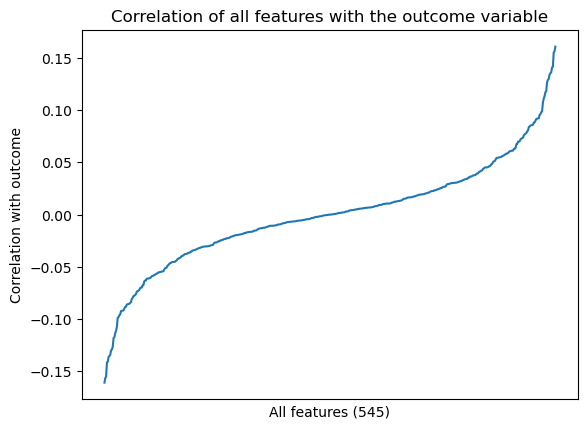

In [11]:
# Show the range of correlations with the target variable
plt.plot(X_train.corrwith(y_train).sort_values())
plt.xticks(ticks=[], labels=[])
plt.xlabel('All features (545)')
plt.ylabel('Correlation with outcome')
plt.title('Correlation of all features with the outcome variable')
plt.show()

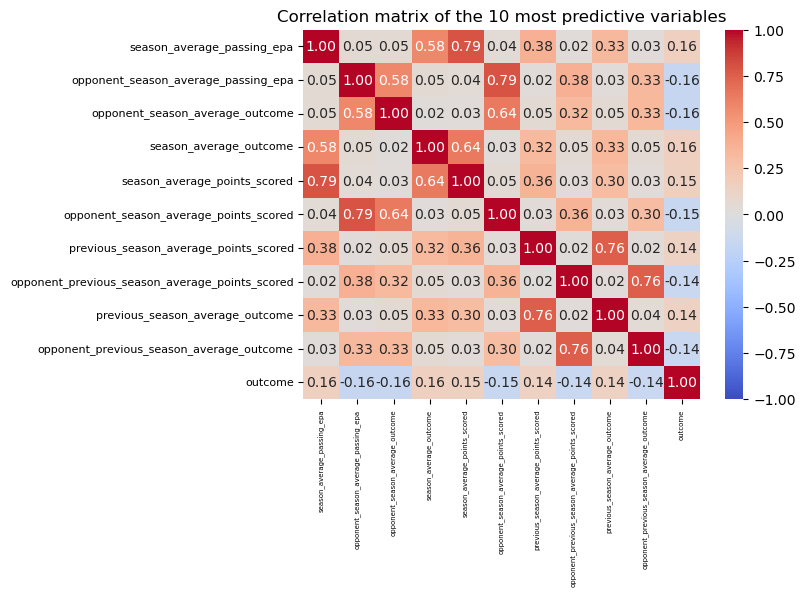

In [12]:
# Correlation matrix of top 10 features
sns.heatmap(df_train[['season_average_passing_epa', 'opponent_season_average_passing_epa',
       'opponent_season_average_outcome', 'season_average_outcome',
       'season_average_points_scored', 'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_previous_season_average_points_scored',
       'previous_season_average_outcome',
       'opponent_previous_season_average_outcome', 'outcome']].corr(), 
       cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('Correlation matrix of the 10 most predictive variables')
plt.xticks(fontsize=5)
plt.yticks(fontsize=8)
plt.show()


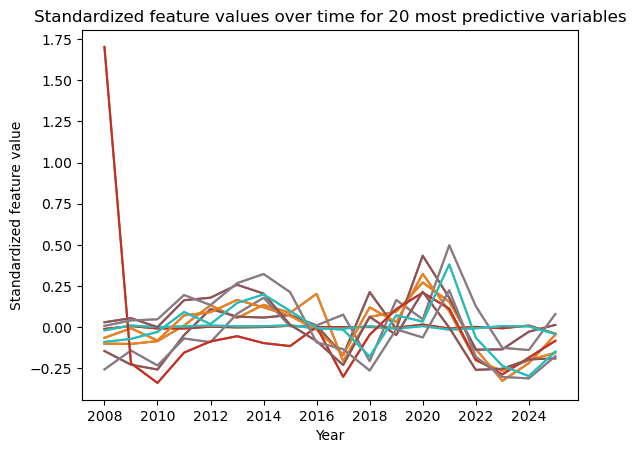

In [13]:
# Plot 20 most correlated variables (standardized) over time
for c in ['season_average_passing_epa', 'opponent_season_average_passing_epa',
       'opponent_season_average_outcome', 'season_average_outcome',
       'season_average_points_scored', 'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_previous_season_average_points_scored',
       'previous_season_average_outcome',
       'opponent_previous_season_average_outcome',
       'opponent_season_average_pat_att', 'season_average_pat_att',
       'opponent_season_average_receiving_epa', 'season_average_receiving_epa',
       'season_average_pat_made', 'opponent_season_average_pat_made',
       'opponent_previous_season_average_pat_made',
       'previous_season_average_pat_made',
       'opponent_previous_season_average_pat_att',
       'previous_season_average_pat_att']:
    plt.plot((df.groupby('season')[c].mean() - df[c].mean())/df[c].std())
plt.xticks(ticks=range(2008, 2026, 2))
plt.xlabel('Year')
plt.ylabel('Standardized feature value')
plt.title('Standardized feature values over time for 20 most predictive variables')
plt.show()

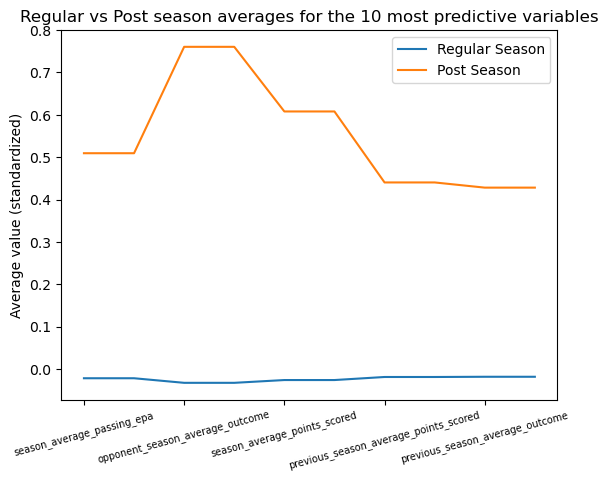

In [14]:
# Plot means of 10 most predictive features in reg vs post season
X_train.groupby('is_postseason')[['season_average_passing_epa', 'opponent_season_average_passing_epa',
       'opponent_season_average_outcome', 'season_average_outcome',
       'season_average_points_scored', 'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_previous_season_average_points_scored',
       'previous_season_average_outcome',
       'opponent_previous_season_average_outcome']].mean().T.plot()
plt.legend(labels=['Regular Season', 'Post Season'])
plt.ylabel('Average value (standardized)')
plt.title('Regular vs Post season averages for the 10 most predictive variables')
plt.xticks(rotation=15, fontsize=7)
plt.show()

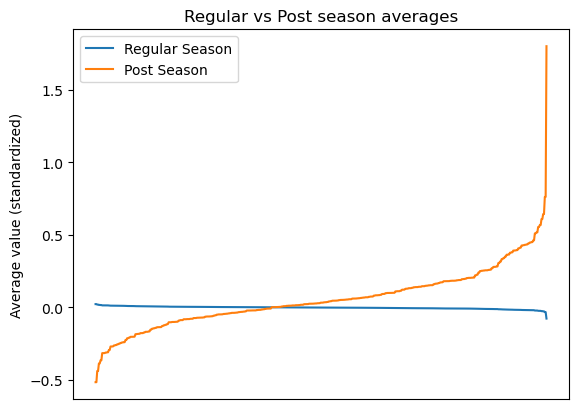

In [15]:
# Plot feature average in reg vs post season
X_train.groupby('is_postseason').mean().T.sort_values(by=X_train.groupby('is_postseason').mean().T.columns[1]).plot()
plt.legend(labels=['Regular Season', 'Post Season'])
plt.ylabel('Average value (standardized)')
plt.title('Regular vs Post season averages')
plt.xticks(ticks=[], labels=[])
plt.show()

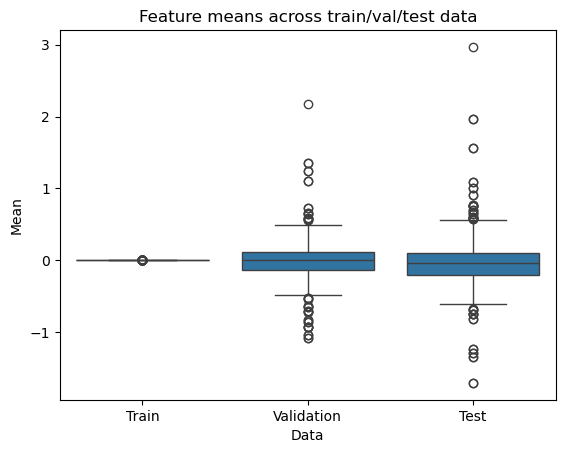

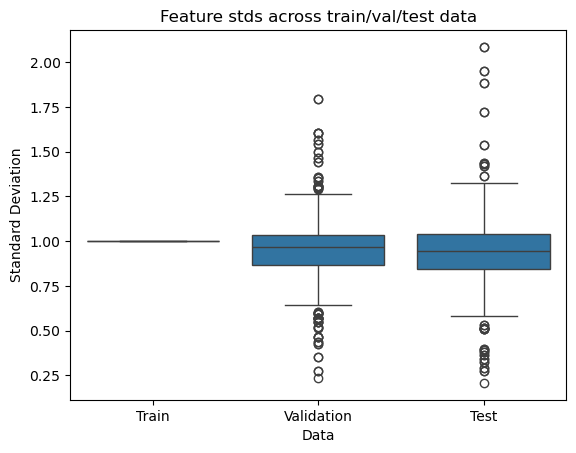

In [16]:
# Feature mean/std in train/val/test
sns.boxplot(
    data=pd.concat([
        X_train.describe().T['mean'].rename('Train'),
        X_val.describe().T['mean'].rename('Validation'),
        X_test.describe().T['mean'].rename('Test')
    ], axis=1).melt(var_name='Data', value_name='Mean'),
    x='Data',
    y='Mean'
)
plt.title('Feature means across train/val/test data')
plt.show()

sns.boxplot(
    data=pd.concat([
        X_train.describe().T['std'].rename('Train'),
        X_val.describe().T['std'].rename('Validation'),
        X_test.describe().T['std'].rename('Test')
    ], axis=1).melt(var_name='Data', value_name='Standard Deviation'),
    x='Data',
    y='Standard Deviation'
)
plt.title('Feature stds across train/val/test data')
plt.show()